In [1]:
import pandas as pd
import numpy as np
import re
import string
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score
from statistics import mean
from sklearn.metrics import hamming_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

from sklearn.metrics import roc_auc_score, confusion_matrix
import statistics
from sklearn.metrics import recall_score

from wordcloud import WordCloud
from collections import Counter

from sklearn.pipeline import Pipeline

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
test_y = pd.read_csv("data/test_labels.csv")

In [3]:
train.tail(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


In [18]:
#Function to remove Punctuation
def remove_punct(text):
    text_nopunct = "".join([char for char in text if char not in string.punctuation])
    # It will discard all punctuations
    return text_nopunct

train['comment_text'] = train['comment_text'].apply(lambda x: remove_punct(x))

In [19]:
train.tail(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159568,ffee36eab5c267c9,Spitzer \n\nUmm theres no actual article for p...,0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,\nAnd I really dont think you understand I c...,0,0,0,0,0,0


In [5]:
train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [6]:
# Labels count 
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train[class_names].apply(lambda x: x.value_counts())

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,144277,157976,151122,159093,151694,158166
1,15294,1595,8449,478,7877,1405


In [7]:
# Normalize
train[class_names].apply(lambda x: x.value_counts(normalize=True))

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0.904156,0.990004,0.947052,0.997004,0.950636,0.991195
1,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805


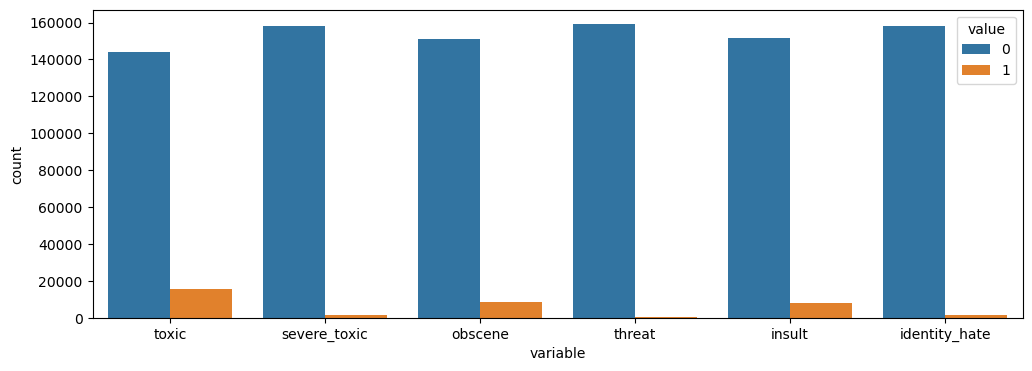

In [8]:
# We see that less than 10% are marked toxic

# plot the chart out for better visualization
plt.figure(figsize=(12,4))
sns.countplot(x="variable", hue="value", data=pd.melt(train[class_names]))

plt.show()

In [9]:
lent = train.comment_text.str.len()
lent.min(), lent.max(), lent.mean(), lent.std()

(6, 5000, 394.0732213246768, 590.7202819048923)

<AxesSubplot:>

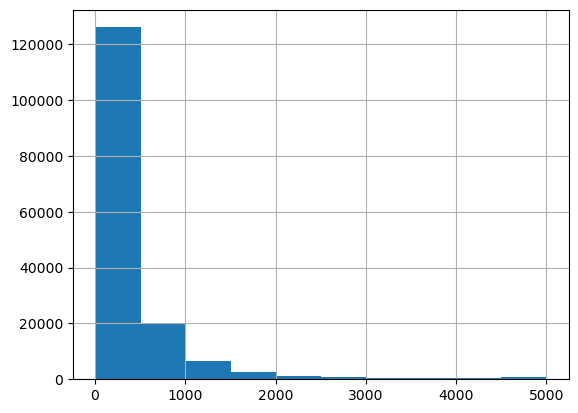

In [10]:
lent.hist()

In [14]:
# Extract and combine all comments flagged as "Toxic
toxic_df = train[train["toxic"] == 1]
toxic_df = toxic_df["comment_text"].reset_index(drop=True)

toxic_text = ""

for i in range(len(toxic_df)):
    toxic_text += " " + toxic_df[i]
    
toxic_text[:100]

' COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK Hey... what is it..\n@ | talk .\nWhat is it... an exclus'

In [16]:
tokens = re.findall(r'\w+', toxic_text)
print("Number of toxic tokens = "+"{:,}\n".format(len(tokens)))
print(tokens[:50])

Number of toxic tokens = 815,264

['COCKSUCKER', 'BEFORE', 'YOU', 'PISS', 'AROUND', 'ON', 'MY', 'WORK', 'Hey', 'what', 'is', 'it', 'talk', 'What', 'is', 'it', 'an', 'exclusive', 'group', 'of', 'some', 'WP', 'TALIBANS', 'who', 'are', 'good', 'at', 'destroying', 'self', 'appointed', 'purist', 'who', 'GANG', 'UP', 'any', 'one', 'who', 'asks', 'them', 'questions', 'abt', 'their', 'ANTI', 'SOCIAL', 'and', 'DESTRUCTIVE', 'non', 'contribution', 'at', 'WP']


In [34]:
# Remove stop words. Ex: silver or gold becomes: silver gold 

import nltk
stop_words = nltk.corpus.stopwords.words('english') # All English Stopwords
#stop_words = set(stopwords.words('english'))

tokens = [t.lower() for t in tokens if t.lower() not in stop_words]
print(Counter(tokens).most_common(50))

[('fuck', 9934), ('wikipedia', 3678), ('shit', 3622), ('like', 3512), ('nigger', 3300), ('fucking', 3289), ('suck', 3235), ('ass', 2939), ('u', 2866), ('go', 2865), ('hate', 2631), ('get', 2300), ('gay', 2239), ('know', 2201), ('page', 2147), ('die', 2082), ('faggot', 2017), ('fat', 1970), ('people', 1873), ('moron', 1862), ('bitch', 1785), ('hi', 1691), ('cunt', 1540), ('one', 1529), ('sucks', 1443), ('stupid', 1439), ('wiki', 1436), ('stop', 1420), ('talk', 1402), ('article', 1394), ('pig', 1355), ('jew', 1350), ('dick', 1303), ('user', 1264), ('penis', 1239), ('think', 1236), ('want', 1220), ('bullshit', 1139), ('life', 1089), ('block', 1089), ('time', 1064), ('asshole', 1042), ('wanker', 1035), ('dont', 1031), ('would', 1021), ('fag', 1012), ('even', 1007), ('bark', 1001), ('balls', 999), ('right', 959)]


In [60]:
from nltk.stem import WordNetLemmatizer
nltk.download ('wordnet')
py_lem = WordNetLemmatizer()
tokens = [py_lem.lemmatize (py_words) for py_words in tokens]
print(Counter(py_lemword).most_common(50))


[nltk_data] Downloading package wordnet to /Users/apple/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[('fuck', 10005), ('suck', 4678), ('wikipedia', 3678), ('shit', 3637), ('like', 3637), ('nigger', 3427), ('u', 3359), ('fucking', 3289), ('go', 3003), ('as', 2939), ('faggot', 2692), ('hate', 2682), ('page', 2587), ('get', 2448), ('know', 2297), ('gay', 2266), ('bitch', 2264), ('die', 2082), ('fat', 1970), ('people', 1933), ('moron', 1932), ('article', 1898), ('cunt', 1799), ('hi', 1691), ('one', 1599), ('user', 1566), ('jew', 1563), ('stupid', 1441), ('wiki', 1436), ('stop', 1429), ('talk', 1415), ('pig', 1385), ('dick', 1375), ('think', 1324), ('want', 1320), ('cock', 1278), ('time', 1265), ('penis', 1254), ('make', 1178), ('life', 1173), ('block', 1153), ('idiot', 1150), ('bullshit', 1144), ('asshole', 1138), ('fag', 1053), ('wanker', 1053), ('ball', 1036), ('dont', 1031), ('right', 1030), ('would', 1021)]


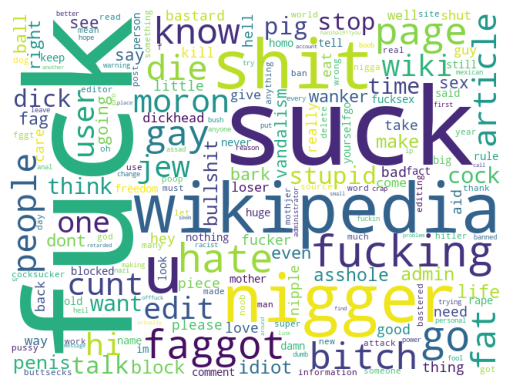

In [61]:
text_wordcloud = " ".join(tokens)
cloud = WordCloud(background_color="white", width=640, height=480, collocations = False).generate(text_wordcloud)

plt.imshow(cloud)
plt.axis("off")
plt.show()

### We can do similarly for other classes. But, we won't. We would build the model. We know that Term Frequency — Inverse Document Frequency (TF-IDF) and Word Embedding are two of the most common methods in NLP to convert sentences to machine readable code. Check this for more details and differences: https://medium.com/@dcameronsteinke/tf-idf-vs-word-embedding-a-comparison-and-code-tutorial-5ba341379ab0

In [65]:
s_toxic_df = train[train["severe_toxic"] == 1]
s_toxic_df = s_toxic_df["comment_text"].reset_index(drop=True)
s_toxic_text = ""
for i in range(len(toxic_df)):
    s_toxic_text += " " + toxic_df[i]

    


some_frac_total_text = toxic_text + s_toxic_text 
print("Characters = "+"{:,}".format(len(some_frac_total_text)))
print("Words = "+"{:,}".format(len(some_frac_total_text.split())))
print("Unique words from first two = "+"{:,}".format(len(set(some_frac_total_text.split()))))

Characters = 9,061,574
Words = 1,568,852
Unique words from first two = 73,682


In [72]:
# combine all the text in training and test set
train_text = train['comment_text']
test_text = test['comment_text']
all_text = pd.concat([train_text, test_text])
all_text.head()

0    Explanation\nWhy the edits made under my usern...
1    Daww He matches this background colour Im seem...
2    Hey man Im really not trying to edit war Its j...
3    \nMore\nI cant make any real suggestions on im...
4    You sir are my hero Any chance you remember wh...
Name: comment_text, dtype: object

In [74]:
%%time
# To simplify our tasks, we will use TfidfVectorizer which is equivalent to CountVectorizer 
# followed by TfidfTransformer to convert a collection of text comments to a matrix of TF-IDF 
# features.
# learn vocabulary and idf from all the text data 
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 1),
    max_features=10000)

word_vectorizer.fit(all_text)
# # default:  ngram_range=(1, 1)
# Recall that ngram is basically "I am good" is 3-gram with two 2-gram "I am" and "am good"

CPU times: user 8.77 s, sys: 187 ms, total: 8.96 s
Wall time: 8.99 s


TfidfVectorizer(max_features=10000, stop_words='english',
                strip_accents='unicode', sublinear_tf=True,
                token_pattern='\\w{1,}')

In [75]:
%%time
# transform words to document-term matrix
train_features = word_vectorizer.transform(train_text)
test_features = word_vectorizer.transform(test_text)

CPU times: user 7.79 s, sys: 90.4 ms, total: 7.88 s
Wall time: 7.89 s


In [76]:
print(type(train_features), "\n")

<class 'scipy.sparse._csr.csr_matrix'> 



In [77]:
print(train_features[6], "\n")

  (0, 9729)	0.3415177482992173
  (0, 6589)	0.6062867060881496
  (0, 1856)	0.7181796833783409 



In [78]:
train_features.shape # Data size x feastures (which is set to 10,000)

(159571, 10000)

## Do logistic regression

In [82]:
%%time
scores = []
submission = pd.DataFrame.from_dict({'id': test['id']})
for class_name in class_names: # We have six of these
    train_target = train[class_name]
    classifier = LogisticRegression(C=1, solver='sag')

    cv_score = np.mean(cross_val_score(classifier, train_features, train_target, cv=3, scoring='roc_auc'))
    scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_name, cv_score))

    classifier.fit(train_features, train_target)
    submission[class_name] = classifier.predict_proba(test_features)[:, 1]
    

print('Total CV score is {}'.format(np.mean(scores)))

submission.to_csv('submission.csv', index=False)

CV score for class toxic is 0.9666130241708886
CV score for class severe_toxic is 0.9842294962846564
CV score for class obscene is 0.9824319017654207
CV score for class threat is 0.9815910359153879
CV score for class insult is 0.9742016896472289
CV score for class identity_hate is 0.9729254081964894
Total CV score is 0.9769987593300119
CPU times: user 14 s, sys: 107 ms, total: 14.1 s
Wall time: 14.1 s


### We will now focus on implementing LSTM (variety of RNN) to see if that improves modeling. 

In [97]:
#train.head(3)
#train.drop["id"]
# https://www.kaggle.com/code/ishraqahmed/lstm-gru-project-dl-iti-ai-43

labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
bigX = train.drop(labels,axis=1)
#bigX = bigX.to_numpy().reshape(-1,) # It has only id and comment_text
bigy = train[labels].to_numpy()
bigX.shape, bigy.shape

((159571, 2), (159571, 6))

In [99]:
# define the train and test dataloader
import torch
train_loader = torch.utils.data.DataLoader(Dataset(bigX,bigy), batch_size=256)

NameError: name 'Dataset' is not defined

In [101]:
from sklearn.model_selection import train_test_split
X_train_dev, X_test, y_train_dev, y_test = train_test_split(bigX, bigy,
                                                    test_size=0.2)

X_train, X_val, y_train, y_val = train_test_split(X_train_dev, y_train_dev,
                                                    test_size=0.2)

In [103]:
from keras.preprocessing.text import Tokenizer
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(bigX)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix_train = pad_sequences(sequences,maxlen=max_len)
#sequences = tok.texts_to_sequences(X_test)
#sequences_matrix_test = pad_sequences(sequences,maxlen=max_len)
sequences = tok.texts_to_sequences(X_val)
sequences_matrix_val = pad_sequences(sequences,maxlen=max_len)
sequences = tok.texts_to_sequences(bigX)
sequences_matrix_big = pad_sequences(sequences,maxlen=max_len)

NotFoundError: dlopen(/Users/apple/anaconda3/lib/python3.9/site-packages/tensorflow-plugins/libmetal_plugin.dylib, 0x0006): Symbol not found: _OBJC_CLASS_$_MPSGraphRandomOpDescriptor
  Referenced from: /Users/apple/anaconda3/lib/python3.9/site-packages/tensorflow-plugins/libmetal_plugin.dylib
  Expected in: /System/Library/Frameworks/MetalPerformanceShadersGraph.framework/Versions/A/MetalPerformanceShadersGraph

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Embedding(max_words,50,input_length=max_len, input_shape=[max_len]))
model.add(layers.LSTM(64, dropout=0.2))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(6, activation='sigmoid'))

model.summary()

In [ ]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(sequences_matrix_train,
                    y_train,
                    epochs=1,
                    batch_size=512,
                    validation_data=(sequences_matrix_val, y_val))

In [ ]:
acc = history.history['accuracy']
val_acc_values = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

model.evaluate(sequences_matrix_test, y_test)

In [ ]:
X_test = pd.read_csv("test.csv")

In [ ]:
id_col = X_test['id']
test = X_test.drop('id', axis=1).to_numpy().reshape(-1,)
sequences = tok.texts_to_sequences(test)
sequences_matrix_test_final = pad_sequences(sequences,maxlen=max_len)
y_pred = model.predict(sequences_matrix_test_final)
y_pred

In [ ]:
prediction_df = pd.DataFrame()
prediction_df['id'] = id_col
prediction_df[labels] = y_pred
prediction_df

In [ ]:
prediction_df.to_csv('submission.csv', index=False)